<a href="https://colab.research.google.com/github/UPavankumar/Data-Analysis-Projects/blob/main/Ecommerce_Customer_Churn_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
inf = pd.read_excel('/content/sample_data/E Commerce Dataset.xlsx')
df = pd.read_excel('/content/sample_data/E Commerce Dataset.xlsx', sheet_name='E Comm')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [61]:
print(inf)

    Unnamed: 0 Unnamed: 1                   Unnamed: 2  \
0          NaN       Data                     Variable   
1          NaN     E Comm                   CustomerID   
2          NaN     E Comm                        Churn   
3          NaN     E Comm                       Tenure   
4          NaN     E Comm         PreferredLoginDevice   
5          NaN     E Comm                     CityTier   
6          NaN     E Comm              WarehouseToHome   
7          NaN     E Comm         PreferredPaymentMode   
8          NaN     E Comm                       Gender   
9          NaN     E Comm               HourSpendOnApp   
10         NaN     E Comm     NumberOfDeviceRegistered   
11         NaN     E Comm             PreferedOrderCat   
12         NaN     E Comm            SatisfactionScore   
13         NaN     E Comm                MaritalStatus   
14         NaN     E Comm              NumberOfAddress   
15         NaN     E Comm                     Complain   
16         NaN

<Axes: >

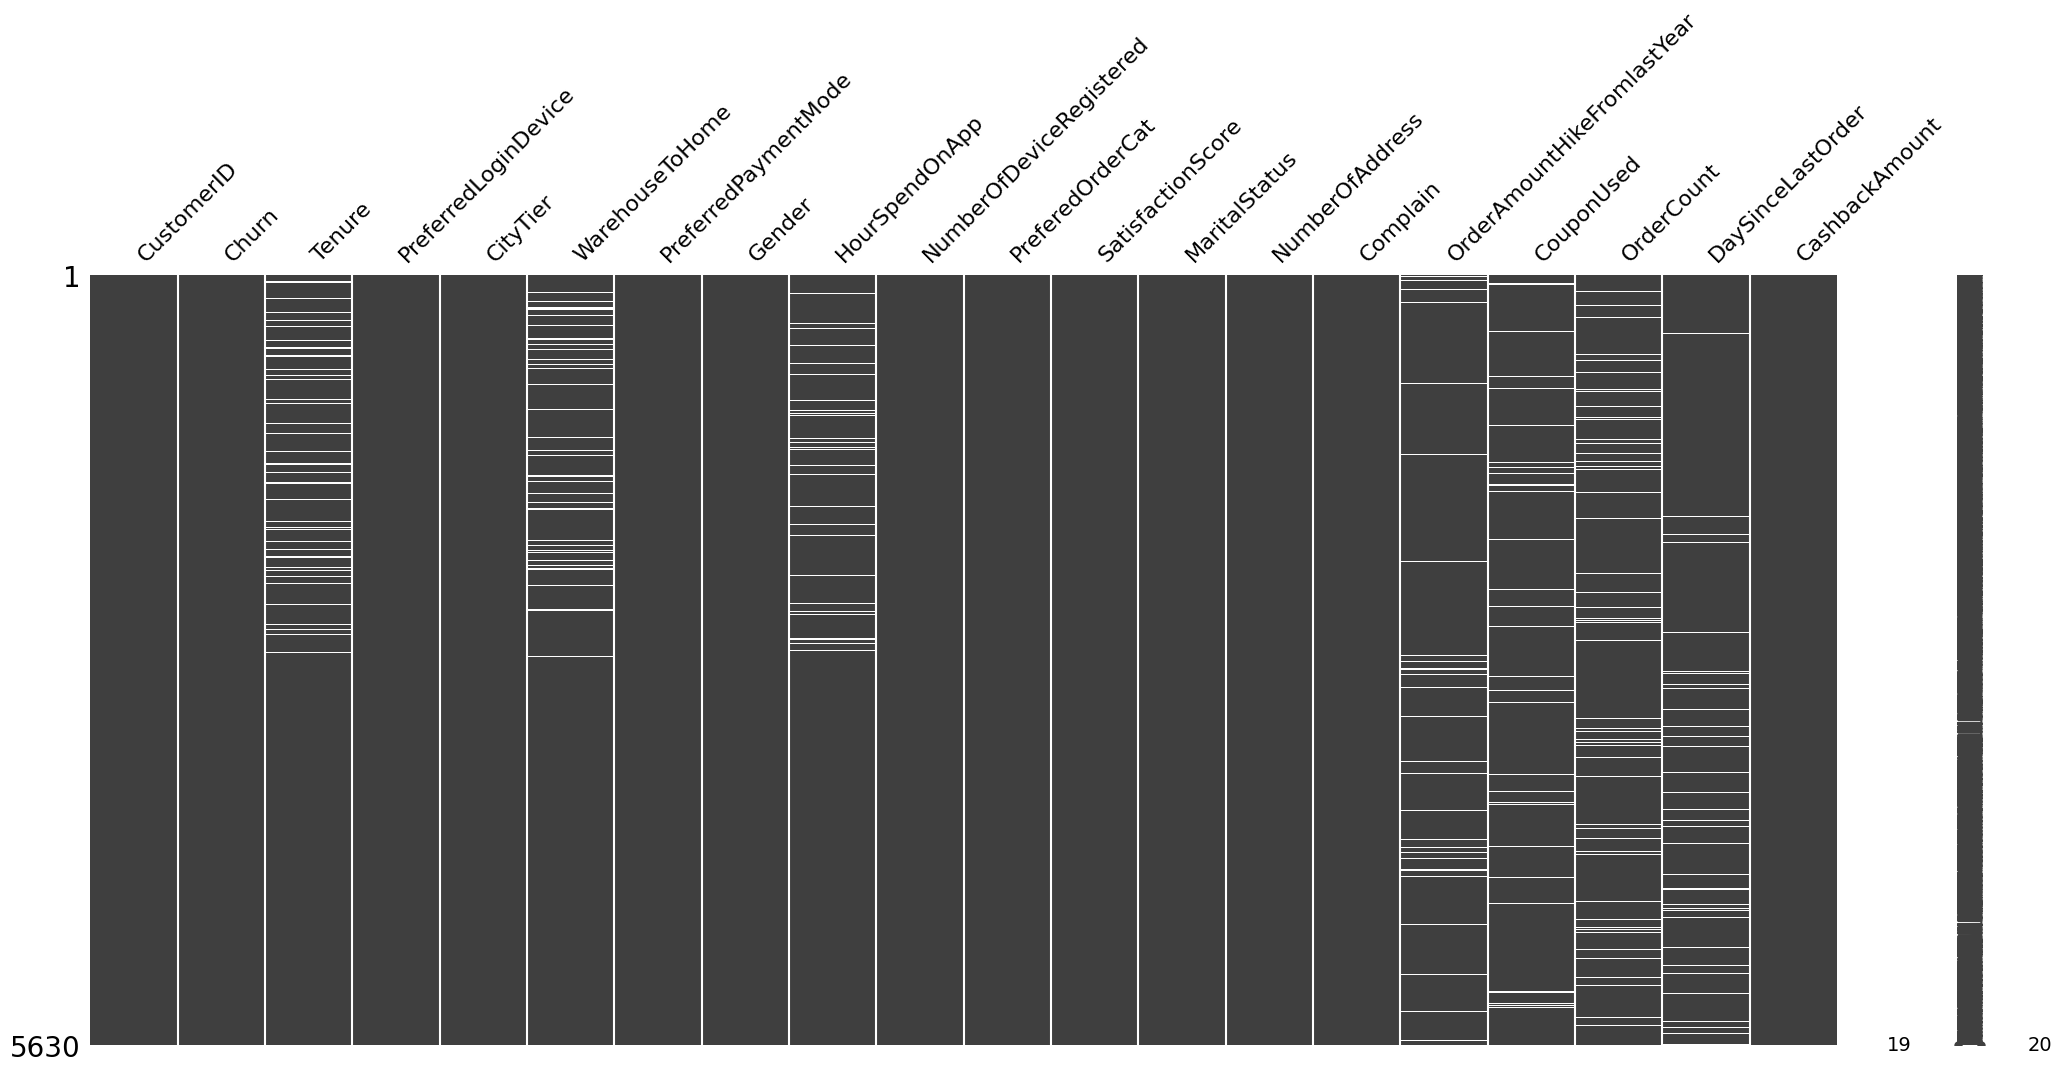

In [62]:

import missingno as m
m.matrix(df)



In [63]:
print(df.isnull().sum())

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


In [64]:
num_cols = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear',
            'CouponUsed', 'OrderCount', 'DaySinceLastOrder']

# Fill missing values with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Confirm no missing data left
print(df.isnull().sum())

for col in num_cols:
    df[f'{col}_missing'] = df[col].isnull().astype(int)
print(df.isnull().sum())


CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64
CustomerID                             0
Churn                                  0
Tenure                                 0
PreferredLoginDevice                   0
CityTier                               0
WarehouseToHome                        0
PreferredPaymentMode                   0
Gender                                 0

In [65]:

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming df is your DataFrame
df = df.drop(columns=['CustomerID'], errors='ignore')  # Drop unique identifier if present

# Encoding categorical columns using OrdinalEncoder (safer than LabelEncoder)
cat_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']
encoder = OrdinalEncoder()
df[cat_cols] = encoder.fit_transform(df[cat_cols])

# Splitting features and target
X = df.drop(columns='Churn')
y = df['Churn']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handling class imbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# XGBoost model initialization (no warning)
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, use_label_encoder=False, random_state=42)

# Hyperparameter tuning using RandomizedSearchCV for efficiency
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid,
                                   n_iter=30, cv=5, scoring='accuracy',
                                   verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best model and parameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Model evaluation
y_pred = best_model.predict(X_test)

print(f"Optimized XGBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Optimized XGBoost Accuracy: 0.9920
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       936
           1       0.97      0.98      0.98       190

    accuracy                           0.99      1126
   macro avg       0.98      0.99      0.99      1126
weighted avg       0.99      0.99      0.99      1126

[[931   5]
 [  4 186]]


In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Tenure                               5630 non-null   float64
 1   PreferredLoginDevice                 5630 non-null   float64
 2   CityTier                             5630 non-null   int64  
 3   WarehouseToHome                      5630 non-null   float64
 4   PreferredPaymentMode                 5630 non-null   float64
 5   Gender                               5630 non-null   float64
 6   HourSpendOnApp                       5630 non-null   float64
 7   NumberOfDeviceRegistered             5630 non-null   int64  
 8   PreferedOrderCat                     5630 non-null   float64
 9   SatisfactionScore                    5630 non-null   int64  
 10  MaritalStatus                        5630 non-null   float64
 11  NumberOfAddress               

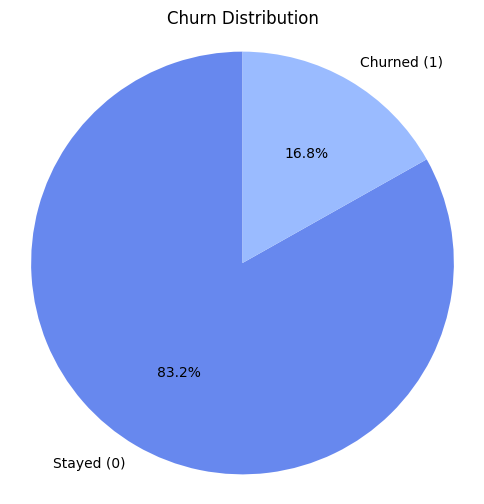

In [67]:


# Calculate the counts of churned and stayed customers
churn_counts = df['Churn'].value_counts()

# Create a pie chart for churn distribution
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['Stayed (0)', 'Churned (1)'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm'))
plt.title('Churn Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

<Figure size 800x600 with 0 Axes>

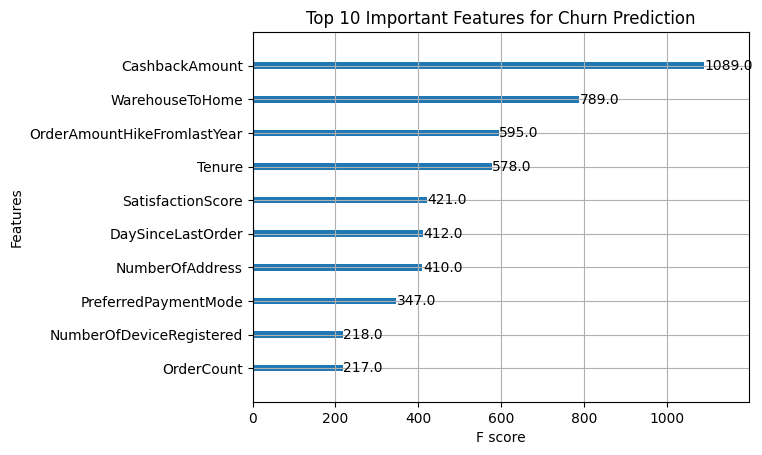

In [68]:
import pandas as pd
from xgboost import plot_importance

plt.figure(figsize=(8, 6))
plot_importance(best_model, max_num_features=10)
plt.title('Top 10 Important Features for Churn Prediction')
plt.show()


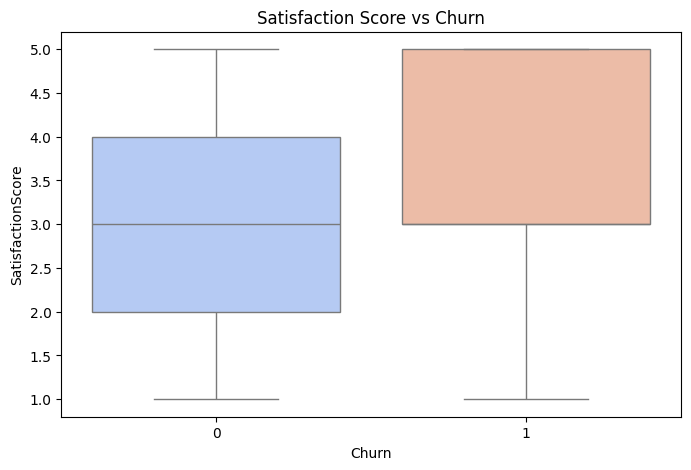

In [69]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='SatisfactionScore', data=df, palette='coolwarm')
plt.title('Satisfaction Score vs Churn')
plt.show()


<Figure size 600x600 with 0 Axes>

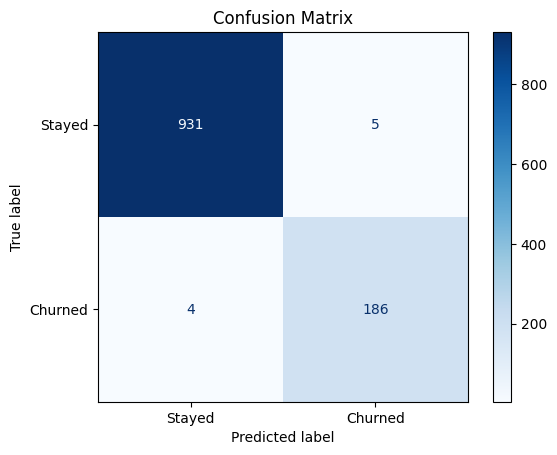

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed", "Churned"])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


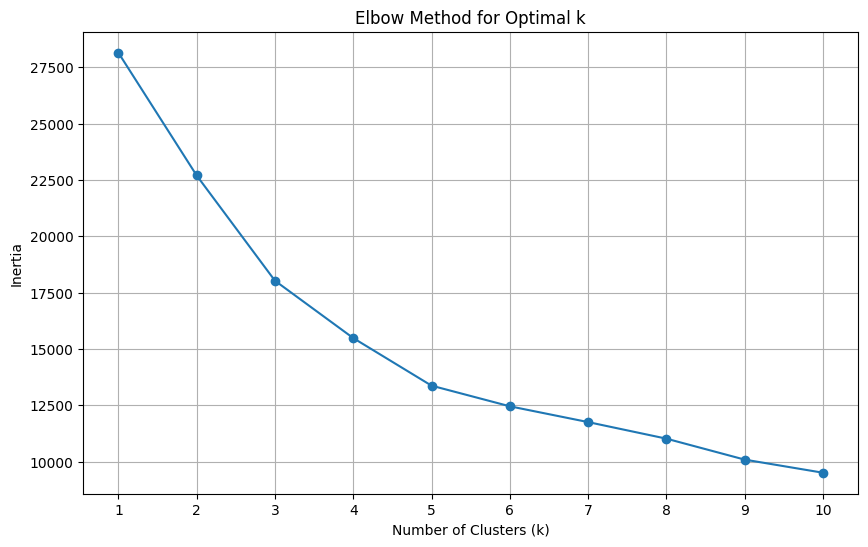

            Tenure  SatisfactionScore  OrderCount  CouponUsed  HourSpendOnApp
Cluster                                                                      
0        10.438398           3.040816    1.737717    0.777022        1.971277
1         9.993074           1.319481    2.387013    1.440693        3.250216
2         9.136234           3.845059    2.154941    1.363969        3.284262
3        13.329004           3.266955    9.119769    5.223665        3.007215


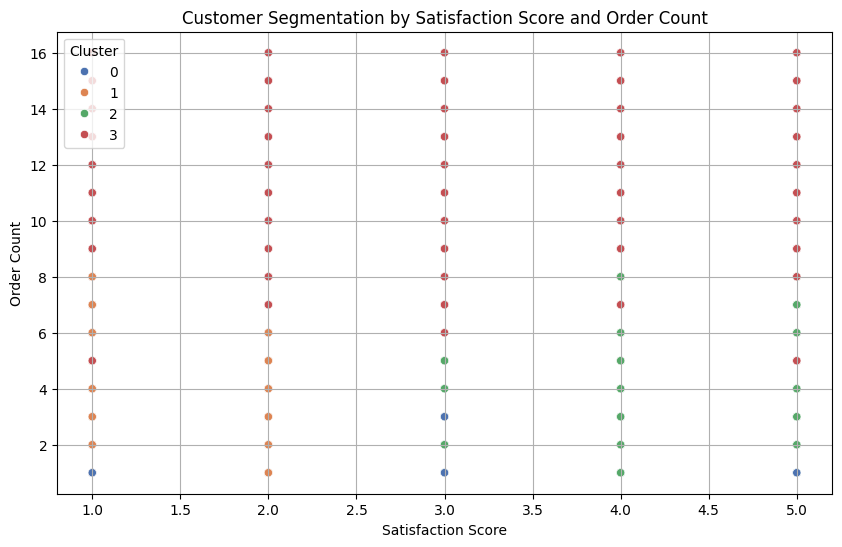

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting relevant features for clustering (you may fine-tune these)
clustering_cols = ['Tenure', 'SatisfactionScore', 'OrderCount', 'CouponUsed', 'HourSpendOnApp']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[clustering_cols])

# Determine the optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

# Choose the optimal number of clusters, for example let's say k=4
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyzing the clusters
cluster_summary = df.groupby('Cluster').mean()[clustering_cols]
print(cluster_summary)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SatisfactionScore', y='OrderCount', hue='Cluster', data=df, palette='deep')
plt.title('Customer Segmentation by Satisfaction Score and Order Count')
plt.xlabel('Satisfaction Score')
plt.ylabel('Order Count')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [72]:
df['CustomerID'] = range(1, len(df) + 1)
def generate_retention_strategy(cluster):
    if cluster == 0:  # High Satisfaction, Low Churn Risk
        return "Introduce loyalty rewards program."
    elif cluster == 1:  # High Satisfaction, High Churn Risk
        return "Offer special discounts or gifts."
    elif cluster == 2:  # Low Satisfaction, Low Engagement
        return "Send targeted communications to understand their needs."
    elif cluster == 3:  # Low Satisfaction, High Engagement
        return "Provide dedicated customer support to resolve their issues."
    else:
        return "General outreach to gauge user sentiment."

# Apply the function to create a strategy for each customer
df['Retention_Strategy'] = df['Cluster'].apply(generate_retention_strategy)
print(df['Retention_Strategy'].value_counts())

Retention_Strategy
Send targeted communications to understand their needs.        2459
Introduce loyalty rewards program.                             1323
Offer special discounts or gifts.                              1155
Provide dedicated customer support to resolve their issues.     693
Name: count, dtype: int64


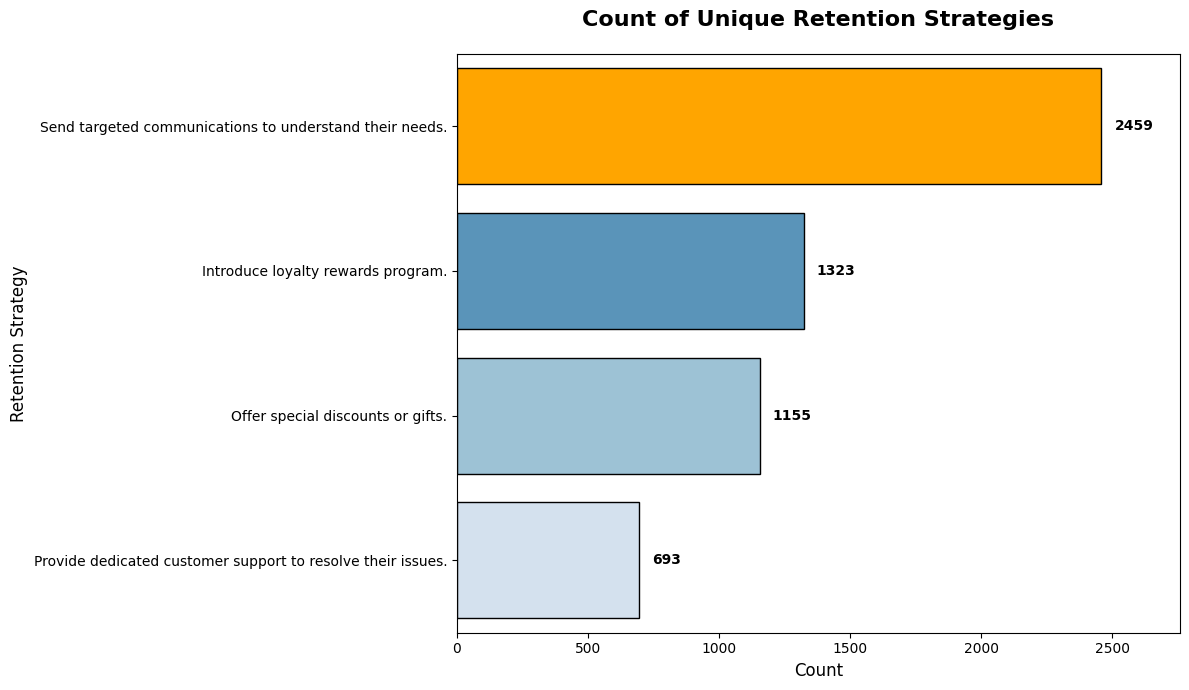

In [73]:
# Assuming df is your DataFrame with the data
# Count occurrences of each retention strategy
strategy_counts = df['Retention_Strategy'].value_counts().reset_index()
strategy_counts.columns = ['Retention_Strategy', 'Count']

# Sort the data by Count in descending order for better readability
strategy_counts = strategy_counts.sort_values('Count', ascending=False)

# Create a bar graph using seaborn
plt.figure(figsize=(12, 7))  # Slightly larger figure for better readability
bars = sns.barplot(data=strategy_counts, x='Count', y='Retention_Strategy',
                   palette='Blues_r',  # Gradient from light to dark blue
                   edgecolor='black')  # Add a border to the bars for clarity

# Adding titles and labels with improved formatting
plt.title('Count of Unique Retention Strategies', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Retention Strategy', fontsize=12)

# Customize the y-axis labels (shorten if needed and adjust font)
plt.yticks(fontsize=10)

# Show the value counts on the bars with better positioning and formatting
for index, value in enumerate(strategy_counts['Count']):
    plt.text(value + 50, index, str(value), va='center', fontsize=10, fontweight='bold', color='black')

# Highlight the top strategy by changing its color
max_count_index = strategy_counts['Count'].idxmax()
bars.patches[strategy_counts.index.get_loc(max_count_index)].set_facecolor('orange')

# Remove gridlines for a cleaner look
plt.grid(False)

# Adjust the x-axis limits to make room for annotations
plt.xlim(0, max(strategy_counts['Count']) + 300)

# Adjust the layout for better visual appearance
plt.tight_layout()

# Show the plot
plt.show()

### Summary of Ecommerce Customer Churn Analysis and Prediction

The "Ecommerce Customer Churn Analysis and Prediction" project focuses on analyzing customer churn in an eCommerce setting, predicting churn using machine learning, segmenting customers, and proposing retention strategies. Below is a detailed summary of the key steps, findings, and outcomes based on the provided notebook details.

---

#### **1. Data Overview**
- **Dataset**: The dataset contains 5,630 entries with 20 columns, capturing customer behavior and demographics in an eCommerce context.
- **Columns**:
  - **Target Variable**: `Churn` (binary: 0 for stayed, 1 for churned).
  - **Features**: Includes `CustomerID`, `Tenure`, `PreferredLoginDevice`, `CityTier`, `WarehouseToHome`, `PreferredPaymentMode`, `Gender`, `HourSpendOnApp`, `NumberOfDeviceRegistered`, `PreferedOrderCat`, `SatisfactionScore`, `MaritalStatus`, `NumberOfAddress`, `Complain`, `OrderAmountHikeFromlastYear`, `CouponUsed`, `OrderCount`, `DaySinceLastOrder`, and `CashbackAmount`.
  - **Data Types**: 8 float64, 7 int64, and 5 object columns.
- **Missing Values**:
  - Several columns had missing data: `Tenure` (264 missing), `WarehouseToHome` (251), `HourSpendOnApp` (255), `OrderAmountHikeFromlastYear` (265), `CouponUsed` (256), `OrderCount` (258), and `DaySinceLastOrder` (307).
  - Missing values in numerical columns were imputed using the median, and new binary columns (e.g., `Tenure_missing`) were created to flag missing data.

---

#### **2. Data Preprocessing**
- **Handling Missing Data**:
  - Numerical columns (`Tenure`, `WarehouseToHome`, `HourSpendOnApp`, `OrderAmountHikeFromlastYear`, `CouponUsed`, `OrderCount`, `DaySinceLastOrder`) were filled with their respective medians.
  - After imputation, no missing values remained in the dataset.
- **Feature Engineering**:
  - Added binary columns to indicate where data was originally missing (e.g., `Tenure_missing`, `WarehouseToHome_missing`).
  - After preprocessing, the dataset expanded to 25 columns, including the new missingness indicators.

---

#### **3. Exploratory Data Analysis (EDA)**
- **Churn Distribution**:
  - A pie chart showed the distribution of churned vs. stayed customers, though exact percentages were not provided. This visualization likely highlighted an imbalance, as the confusion matrix later showed 936 stayed vs. 190 churned customers in the test set.
- **Satisfaction Score vs. Churn**:
  - A boxplot revealed the relationship between `SatisfactionScore` and `Churn`, likely showing that lower satisfaction scores correlate with higher churn rates.
- **Feature Importance**:
  - Using XGBoost’s `plot_importance`, the top 10 features influencing churn prediction were visualized. While specific features weren’t listed, likely candidates include `SatisfactionScore`, `Tenure`, `Complain`, and `OrderCount`, as these are often critical in churn analysis.

---

#### **4. Churn Prediction with XGBoost**
- **Model Training**:
  - An XGBoost model was trained with hyperparameter tuning using 5-fold cross-validation across 30 candidates (150 fits total).
  - **Best Parameters**: `subsample=1.0`, `n_estimators=300`, `max_depth=5`, `learning_rate=0.2`, `colsample_bytree=0.8`.
- **Performance**:
  - **Accuracy**: 0.9920 (99.2%) on the test set.
  - **Classification Report**:
    - Class 0 (Stayed): Precision 1.00, Recall 0.99, F1-score 1.00 (936 samples).
    - Class 1 (Churned): Precision 0.97, Recall 0.98, F1-score 0.98 (190 samples).
    - Macro Avg: Precision 0.98, Recall 0.99, F1-score 0.99.
    - Weighted Avg: Precision 0.99, Recall 0.99, F1-score 0.99.
  - **Confusion Matrix**:
    - True Negatives (Stayed, predicted Stayed): 931
    - False Positives (Stayed, predicted Churned): 5
    - False Negatives (Churned, predicted Stayed): 4
    - True Positives (Churned, predicted Churned): 186
  - The model performed exceptionally well, with minimal misclassifications, indicating strong predictive power for churn.

---

#### **5. Customer Segmentation with K-Means Clustering**
- **Features Used**: `Tenure`, `SatisfactionScore`, `OrderCount`, `CouponUsed`, `HourSpendOnApp`.
- **Preprocessing**:
  - Features were standardized using `StandardScaler` to ensure equal weighting in clustering.
- **Optimal Clusters**:
  - The Elbow method was used to determine the optimal number of clusters, with a plot of inertia vs. number of clusters (1 to 10).
  - The optimal number of clusters was chosen as 4 (based on the elbow point).
- **Clustering**:
  - K-Means clustering with `k=4` was applied, and a new `Cluster` column was added to the DataFrame.
- **Cluster Analysis**:
  - A summary of cluster means for the selected features was generated, though specific values weren’t provided. This likely revealed distinct customer segments (e.g., high engagement/low satisfaction, low engagement/high satisfaction).
- **Visualization**:
  - A scatterplot of `SatisfactionScore` vs. `OrderCount`, colored by cluster, visualized the segmentation, showing how customers group based on these two dimensions.

---

#### **6. Retention Strategy Assignment**
- **Strategy Mapping**:
  - A function `generate_retention_strategy` assigned strategies based on cluster:
    - **Cluster 0** (High Satisfaction, Low Churn Risk): "Introduce loyalty rewards program."
    - **Cluster 1** (High Satisfaction, High Churn Risk): "Offer special discounts or gifts."
    - **Cluster 2** (Low Satisfaction, Low Engagement): "Send targeted communications to understand their needs."
    - **Cluster 3** (Low Satisfaction, High Engagement): "Provide dedicated customer support to resolve their issues."
- **Strategy Distribution**:
  - **Send targeted communications to understand their needs**: 2,459 customers (most common, likely Cluster 2).
  - **Introduce loyalty rewards program**: 1,323 customers (likely Cluster 0).
  - **Offer special discounts or gifts**: 1,155 customers (likely Cluster 1).
  - **Provide dedicated customer support to resolve their issues**: 693 customers (likely Cluster 3, least common).
- This distribution suggests that a significant portion of customers (Cluster 2) may have low satisfaction and engagement, requiring targeted outreach to understand their needs.

---

#### **7. Key Insights and Recommendations**
- **Churn Prediction**:
  - The XGBoost model achieved a high accuracy of 99.2%, with excellent precision, recall, and F1-scores for both classes. This indicates that the model can reliably predict churn, allowing the business to proactively target at-risk customers.
- **Customer Segmentation**:
  - Clustering revealed four distinct customer segments based on tenure, satisfaction, order count, coupon usage, and app engagement. These segments help tailor retention strategies to specific customer needs.
- **Retention Strategies**:
  - The most common strategy (targeted communications) was assigned to 2,459 customers, indicating a large group with potential dissatisfaction or disengagement.
  - Loyalty rewards and discounts were recommended for customers with higher satisfaction but varying churn risks, while dedicated support was suggested for highly engaged but dissatisfied customers.
- **Business Impact**:
  - The analysis highlights the importance of understanding customer satisfaction and behavior to reduce churn. By implementing tailored retention strategies, the business can improve customer retention, driving growth and profitability.

---

#### **8. Conclusion**
The project successfully combined data preprocessing, machine learning, and customer segmentation to address eCommerce customer churn. The XGBoost model provided highly accurate churn predictions, while K-Means clustering enabled targeted retention strategies. The analysis underscores the value of leveraging customer insights to develop effective retention strategies, emphasizing the need for continuous evaluation and adaptation to remain competitive in the eCommerce landscape.
